# Dynamical networks: dynamics of networks
## Spreding on networks 


The main resources on spreading on networks can be found in [1,2].


We start with the simplest class of spreading, viral spreading on a network. This is a similar process to what you might observe in the case of rumor or inovation spreading in a social network. At each step, the "healthy" neighbors of any of the infectious nodes gets infected with fixed probability 𝑝.

For more details on models in this notebook check B.Gonzales tutorials https://github.com/Dataforscience/networks

1. Temporal networks, Saramaki, Holme, https://arxiv.org/abs/1108.1780
2. Spreading, Vespigniani, et al. https://arxiv.org/abs/1408.2701


## Spreading and diffusion in continuous domain 

The main resources about diffusion are [3].

3. First steps in random walks, Klafter, Sokolov, 2011





In [5]:


from collections import Counter
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap


In [8]:
# IMPORTANT: we need to import class
#we import is from the previous notebook dynamical_networks.ipynb
#we use setup from https://github.com/Dataforscience/networks 
#from Graph import *

#create new class Graph 

class Graph:
    def __init__(self, directed=False):
        self._nodes = {}
        self._edges = {}
        self._directed = directed

#adding methods to this class

def add_method(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

@add_method(Graph)
def add_node(self, node, **kwargs):
    self._nodes[node] = kwargs    
    
@add_method(Graph)
def add_nodes_from(self, nodes, **kwargs):
    for node in nodes:
        if isinstance(node, tuple):
            self._nodes[node[0]] = node[1:]
        else:
            self._nodes[node] = kwargs    
        
@add_method(Graph)
def nodes(self):
    return list(self._nodes.keys())        



@add_method(Graph)
def add_edge(self, node_i, node_j, **kwargs):
    if node_i not in self._nodes:
        self.add_node(node_i)
    
    if node_j not in self._nodes:
        self.add_node(node_j)
    
    if node_i not in self._edges:
        self._edges[node_i] = {}
        
    if node_j not in self._edges[node_i]:
        self._edges[node_i][node_j] = {}
        
    self._edges[node_i][node_j] = kwargs
    
    if not self._directed:
        if node_j not in self._edges:
            self._edges[node_j] = {}

        if node_i not in self._edges[node_j]:
            self._edges[node_j][node_i] = {}

        self._edges[node_j][node_i] = kwargs
        
        
@add_method(Graph)
def add_edges_from(self, edges, **kwargs):
    for edge in edges:
        self.add_edge(*edge, **kwargs)
        
        
@add_method(Graph)
def degree_distribution(self, normalize=True):
    deg = self.degrees()
    dist = Graph._build_distribution(deg, normalize)
    
    return dist      

@add_method(Graph)
def degrees(self):
    deg = {}
    
    for node in self._nodes:
        if node in self._edges:
            deg[node] =  len(self._edges[node])
        else:
            deg[node] = 0
    
    return deg


@add_method(Graph)
def _build_distribution(data, normalize=True):
    values = data.values()
    dist = list(Counter(values).items())
    dist.sort(key=lambda x:x[0])
    dist = np.array(dist, dtype='float')
           
    if normalize:
        norm = dist.T[1].sum()
        dist.T[1] /= norm
    
    return dist


#@add_method(Graph) # we can add methods to new class as in https://github.com/Dataforscience/networks


@add_method(Graph)
def erdos_renyi_graph(N, p):
    nodes = list(range(N))
    edges = []
    
    for i in range(N):
        for j in range(i+1, N):
            if np.random.random() < p:
                edges.append((i, j))
    
    G = Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G

@add_method(Graph)
def barabasi_albert_graph(N):
    G = Graph()

    nodes = range(N)
    G.add_nodes_from(nodes)

    edges = [0,1,1,2,2,0]

    for node_i in range(3, N):
        pos = np.random.randint(len(edges))
        node_j = edges[pos]

        edges.append(node_i)
        edges.append(node_j)

    edges = zip(nodes, edges[1::2])

    G.add_edges_from(edges)

    return G

ER1 = Graph.erdos_renyi_graph(100, 0.1)






In [9]:

#we add method for viral spreading on a network Graph


@add_method(Graph)
def number_of_edges(self):
    n_edges = 0
    
    for node_i in self._edges:
        n_edges += len(self._edges[node_i])
    
    # If the graph is undirected, don't double count the edges
    if not self._directed:
        n_edges /= 2
    
    return n_edges

@add_method(Graph)
def neighbours(self, node):
    if node in self._edges:
        return list(self._edges[node].keys())
    else:
        return []

@add_method(Graph)
def viral_spread(self, beta, timesteps, seed):
    '''
    parameters of viral spreading:
    beta - parameter of spreading, probability 
    timesteps - number of steps of spreading
    '''
    
    N = len(self._nodes)

    configuration = np.zeros((timesteps, N), dtype='int') # set of values for each node
    configuration[0, seed] = 1

    for t in range(0, timesteps-1):
        configuration[t+1] = np.copy(configuration[t])

        for i in range(N):
            if configuration[t][i] == 1:
                for neighbour in self.neighbours(i):
                    if configuration[t][neighbour] == 0:
                        prob = np.random.random()

                        if prob < beta:
                            configuration[t+1][neighbour] = 1

                        break
    #the program returns a configuration of a network
    return configuration 

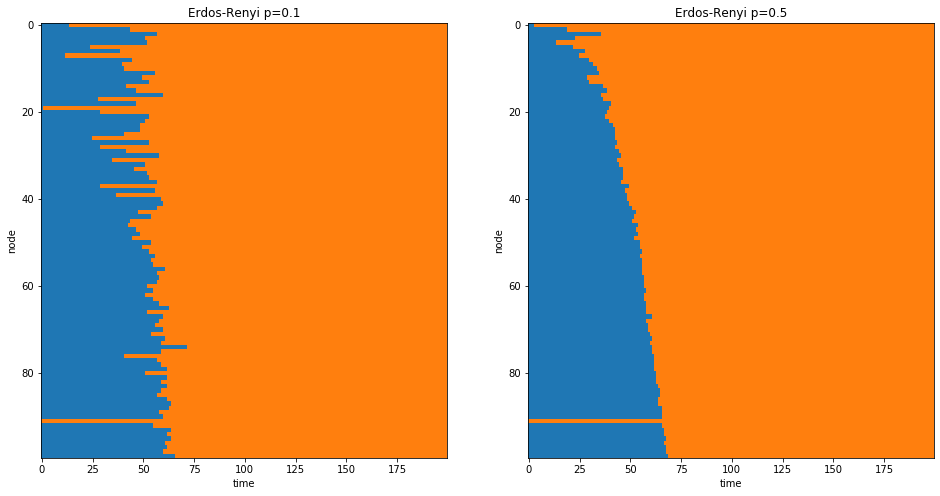

In [10]:
#compare viral spreading on different types of networks

#seed node for spreading
seed = np.random.randint(100)

#WS = Graph.watts_strogatz_graph(100, 4, 0.02)
p1 = 0.1
p2 = 0.5
ER1 = Graph.erdos_renyi_graph(100, p1)
ER2 = Graph.erdos_renyi_graph(100, p2)


# run viral spreading on a network
# result is vector of configuration of network with states

beta = 0.1 # parameter of spreading
ER1_configuration = ER1.viral_spread(0.1, 200, seed)
ER2_configuration = ER2.viral_spread(0.1, 200, seed)


#now we show how spreading can change in time
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cmap = LinearSegmentedColormap.from_list('d4sci', colors=[colors[0], colors[1]])

fig, ax_lst = plt.subplots(1, 2, figsize=(16, 8))
ax_lst[0].imshow(ER1_configuration.T, aspect='auto', cmap=cmap)
ax_lst[0].set_xlabel('time')
ax_lst[0].set_ylabel('node')
ax_lst[0].set_title('Erdos-Renyi p='+str(p1))

ax_lst[1].imshow(ER2_configuration.T, aspect='auto', cmap=cmap)
ax_lst[1].set_xlabel('time')
ax_lst[1].set_ylabel('node')
ax_lst[1].set_title('Erdos-Renyi p='+str(p2))

plt.show()

# Spreading in continuous space 
Here we visualise random walk in continuous domain. If we put several random walks in initial location, it would give us diffusion of material.

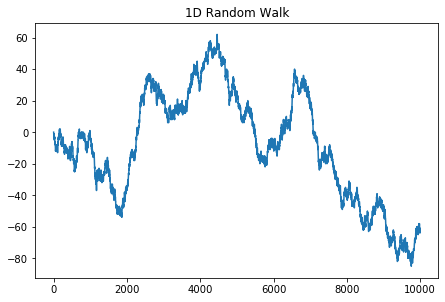

In [2]:

from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt
#colors = cycle(‘bgrcmykbgrcmykbgrcmykbgrcmyk’)
import networkx as nx
import numpy as np

'''
Now let us visualise random walk in 1D
'''
# Define parameters for the walk
dims = 1
step_n = 10000
step_set = [-1, 0, 1]
size = 10 
sizefig = 10

origin = np.zeros((1,dims))
# Simulate steps in 1D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1]
stop = path[-1:]

# print(steps)
# Plot the random walk path

#fig =  plt.figure(figsize = (8, 8))#plt.figure(figsize=(sizefig,sizefig))
#fig = plt.figure(figsize=(8,4),dpi=200)
#ax = plt.subplot(332)#fig.add_subplot(111)

#ax.scatter(np.arange(step_n+1), path, c=’blue’,alpha=0.25,s=0.05);
plt.plot(path)#,c=’blue’,alpha=0.5,lw=0.5,ls=’ — ‘,);
plt.plot(0, start)#,c=’red’, marker=’+’)
plt.plot(step_n, stop)#, c=’black’, marker=’o’)
plt.title('1D Random Walk')
plt.tight_layout(pad=0)
plt.show()

# Spreading SIR model 

The SIR model is one of the simplest compartmental models (NOT neccesarily on networks), and many models are derivations of this basic form. The model consists of three compartments– S for the number susceptible, I for the number of infectious, and R for the number recovered (or immune). This model is reasonably predictive for infectious diseases which are transmitted from human to human, and where recovery confers lasting resistance, such as measles, mumps and rubella. 



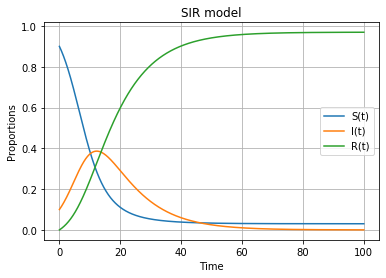

In [5]:
import scipy.integrate
import numpy
import matplotlib.pyplot as plt

def SIR_model(y,t,beta,gamma):
    S,I,R=y
    dS_dt=-beta*S*I
    dI_dt=beta*S*I-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

S0=0.9
I0=0.1
R0=0.0
beta=0.35
gamma=0.1

t=numpy.linspace(0,100,10000)

solution=scipy.integrate.odeint(SIR_model,[S0,I0,R0],t,args=(beta,gamma))
solution=numpy.array(solution)

plt.figure(figsize=[6,4])
plt.plot(t,solution[:,0],label="S(t)")
plt.plot(t,solution[:,1],label="I(t)")
plt.plot(t,solution[:,2],label="R(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

# Spreading SIR model on networks

In [ ]:
#for this one can install SI, SIR models before in the environment where you run it

from GillEpi import SI, SIS, SIR, SIRS
from GillEpi.agent_based_epidemics import SIR as AB_SIR
from GillEpi.agent_based_epidemics import SIS as AB_SIS

import GillEpi
import matplotlib.pyplot as plt
import networkx as nx

N = 100
k = 8
p = k / (N-1.0)
G = nx.fast_gnp_random_graph(N, p)

R0 = 1.5
recovery_rate = 1.0
infection_rate = R0 * recovery_rate / k
tmax = 1000

sis = GillEpi.SIS(
                  G,
                  infection_rate = infection_rate,
                  recovery_rate = recovery_rate,
                 )

# simulate
sis.simulate(tmax)

# plot infected cluster
i, t = sis.get_i_of_t()
plt.step(t,i)

plt.show()